In [1]:
from IPython.display import clear_output
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam

In [3]:
from nn_utils import AE_3D_small, AE_3D_small_v2, AE_big, AE_big_no_last_bias, AE_3D_50, AE_3D_50_no_last_bias, AE_3D_50cone, AE_3D_100, AE_3D_200, AE_3D_500cone_bn
from ae_utils import *

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
PATH = 'data/4D/'
test_pickle = f'{PATH}all_jets_test_4D_100_percent.pkl'
train_pickle = f'{PATH}all_jets_train_4D_100_percent.pkl'

In [7]:
# List of AutoEncoders to compare
autoencoders = [AE_3D_small, AE_3D_small_v2, AE_big, AE_big_no_last_bias, AE_3D_50, AE_3D_50_no_last_bias, AE_3D_50cone, AE_3D_100, AE_3D_200, AE_3D_500cone_bn]

In [8]:
# Hyperparameters
num_epochs = 10
batch_size = 128
weight_decay = 1e-6
learning_rate = 1e-4

## Initialise the Datasets

In [9]:
# Ratio to split the dataset into Training and Validation sets
train_ratio = 0.8

# Initialise the datasets
tv_dataset = AllJetsDataset(train_pickle)

# Split into Train and Validation datasets
train_size = int(len(tv_dataset) * train_ratio)
validation_size = len(tv_dataset) - train_size
train_dataset, validation_dataset = random_split(tv_dataset, [train_size, validation_size])

# Initialise the test dataset
test_dataset = AllJetsDataset(test_pickle)

datasets = Datasets(train_dataset, validation_dataset, test_dataset)

## Initialise the AutoEncoders

In [10]:
AE_Instance = namedtuple('AE_Instance', ['autoencoder', 'loss', 'optimizer', 'trainer'])
AE_Instances = {}
for ae in autoencoders:
    autoencoder = ae().cuda()
    loss_function = LossFunction(nn.MSELoss(), 'MSE')
    optimizer = Adam(autoencoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
    trainer = AE_Trainer(
        autoencoder=autoencoder, 
        datasets=datasets, 
        loss_func=loss_function, 
        optimiser=optimizer, 
        num_epochs=num_epochs,
        batch_size=batch_size)
    AE_Instances[autoencoder.__class__.__name__] = AE_Instance(autoencoder, loss_function, optimizer, trainer)

## Train

In [11]:
for name, AE in AE_Instances.items():
    AE.trainer.train()

Training AE_3D_small | Epoch: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s, Train_Loss=0.251, Validation_Loss=0.278]
Training AE_3D_small_v2 | Epoch: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it, Train_Loss=0.0959, Validation_Loss=0.0794]
Training AE_big | Epoch: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it, Train_Loss=0.286, Validation_Loss=0.308]
Training AE_big_no_last_bias | Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it, Train_Loss=0.297, Validation_Loss=0.298]
Training AE_3D_50 | Epoch: 100%|██████████| 10/10 [00:21<00:00,  2.14s/it, Train_Loss=0.0342, Validation_Loss=0.033]
Training AE_3D_50_no_last_bias | Epoch: 100%|██████████| 10/10 [00:20<00:00,  2.07s/it, Train_Loss=0.0336, Validation_Loss=0.0324]
Training AE_3D_50cone | Epoch: 100%|██████████| 10/10 [00:21<00:00,  2.15s/it, Train_Loss=0.0442, Validation_Loss=0.0362]
Training AE_3D_100 | Epoch: 100%|██████████| 10/10 [00:21<00:00,  2.20s/it, Train_Loss=0.0401, Validation_Loss=0.0307]
Training AE_3D_200 | Epoch:

## Compare

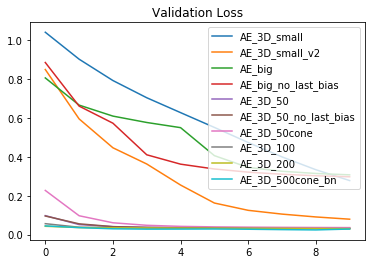

In [13]:
# Plot the validation losses
for name, AE in AE_Instances.items():
    plt.title("Validation Loss")
    plt.plot(AE.trainer.epoch_validation_loss, label=name)
    plt.legend()